In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost Threshold Target Encoding
Do not blend in the overall mean, set unknown to NA instead

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib

In [3]:
from pathlib import Path

In [4]:
from sklearn.preprocessing import TargetEncoder

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
import sklearn as sk
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [7]:
from sba_gnn.sba_gnn import sg_plot, sg_thresh_encoder
from sba_gnn.sba_gnn.sg_thresh_encoder import TargetThreshEncoder

## Import Processed Datasets

##### Get loans data, append clusters

In [8]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet'))

##### NAICS levels to select NAICS-like clusters

In [9]:
train_df = sba_loans[sba_loans['dset'] == 'train']

## Fit the Encoder
Also save it for later

In [11]:
tt_enc = TargetThreshEncoder()

In [12]:
# Fit the encoder
tt_enc.fit(train_df['NAICS'], train_df['target'])

In [13]:
with open(Path(setup.temp_path).joinpath('A11_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(tt_enc, fout)

In [17]:
with open(Path(setup.temp_path).joinpath('A11_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(tt_enc, fout)

In [22]:
# Transform the data
enc_val = tt_enc.transform(sba_loans['NAICS']) \
    .rename(columns={'NAICS':'tt_NAICS'})
print(enc_val.shape)

(688081, 1)


In [23]:
enc_val.head(3)

,tt_NAICS
index,
0,0.229316
1,0.141762
2,0.040818


In [24]:
enc_val.isna().sum()

tt_NAICS    95669
dtype: int64

In [25]:
# Save the values
pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=['count', 'response'], errors='ignore'), enc_val], axis = 1) \
    .to_parquet(Path(setup.temp_path).joinpath('A11_DATA_encodings.parquet'))

In [26]:
sba_loans = pd.concat([sba_loans.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
print(sba_loans.shape)

(688081, 59)


In [27]:
sba_loans[['target'] + list(enc_val.columns)].corr()

,target,tt_NAICS
target,1.00000,0.23591
tt_NAICS,0.23591,1.00000


In [28]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [29]:
predictor_features = setup.predictor_features + list(enc_val.columns)
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'tt_NAICS']


In [30]:
with open(Path(setup.temp_path).joinpath('A11_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [31]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [32]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [33]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [34]:
xgb_model = xgb_model.set_params(**xgb_params)

In [35]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50047	validation_1-logloss:0.50401
[1]	validation_0-logloss:0.49300	validation_1-logloss:0.49676
[2]	validation_0-logloss:0.48673	validation_1-logloss:0.49069
[3]	validation_0-logloss:0.48138	validation_1-logloss:0.48549
[4]	validation_0-logloss:0.47686	validation_1-logloss:0.48113
[5]	validation_0-logloss:0.47298	validation_1-logloss:0.47739
[6]	validation_0-logloss:0.46971	validation_1-logloss:0.47428
[7]	validation_0-logloss:0.46690	validation_1-logloss:0.47161
[8]	validation_0-logloss:0.46444	validation_1-logloss:0.46927
[9]	validation_0-logloss:0.46229	validation_1-logloss:0.46727
[10]	validation_0-logloss:0.46041	validation_1-logloss:0.46553
[11]	validation_0-logloss:0.45885	validation_1-logloss:0.46409
[12]	validation_0-logloss:0.45751	validation_1-logloss:0.46288
[13]	validation_0-logloss:0.45635	validation_1-logloss:0.46181
[14]	validation_0-logloss:0.45533	validation_1-logloss:0.46090
[15]	validation_0-logloss:0.45434	validation_1-logloss:0.46003
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [37]:
xgb_model.save_model(Path(setup.temp_path).joinpath('A11_MODEL_xgboost.json'))

In [38]:
with open(Path(setup.temp_path).joinpath('A11_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [39]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [40]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.183522,0.114817,0.016148,0.672094,0.169955
1,0.282189,0.110497,0.016965,0.684337,0.286150


## Decision Threshold
Max f1, on training data

In [41]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [42]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [43]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('A11_REPORT_thresh_tune.csv'), index=False)

In [44]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.452881
11,0.22,0.452664


##### Apply decision threshold
All datasets

In [45]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [46]:
pred_df['predict_bin'].value_counts()

predict_bin
0    409096
1    278985
Name: count, dtype: int64

In [47]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A11_DATA_combined_predictions.parquet'))

## Metrics

In [48]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A11_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.671693,0.436899,0.328950,0.650303,0.368132,0.728266,NaN
1,train,0.663097,0.452881,0.339162,0.681325,0.391741,0.734313,NaN
2,val,0.660282,0.449832,0.338736,0.669366,0.384843,0.726402,NaN
0,test,0.659483,0.448981,0.336491,0.674452,0.382759,0.728253,0.0
1,test,0.689233,0.416768,0.316230,0.611031,0.345690,0.727347,1.0


100: 0.383476 / 0.349328  50 : 0.385128 / 0.348482. 10: 0.384807/0.384807.  1000: 0.379283/0.348526

dgi 3 only 0.377552/0.355, dgi 20 0.384056 / 0.345640

## Lift
Test data

In [49]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

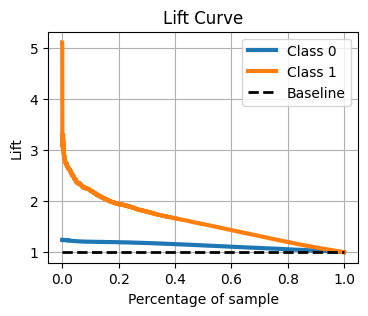

In [50]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A11_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [51]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [52]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('A11_REPORT_importance_gain.csv'), index=True)

In [53]:
feat_impgain.head()

,importance
urban_flag,365.191742
LowDoc,114.649315
tt_NAICS,81.152046
DisbursementGross,53.405827
franchise_flag,21.643766


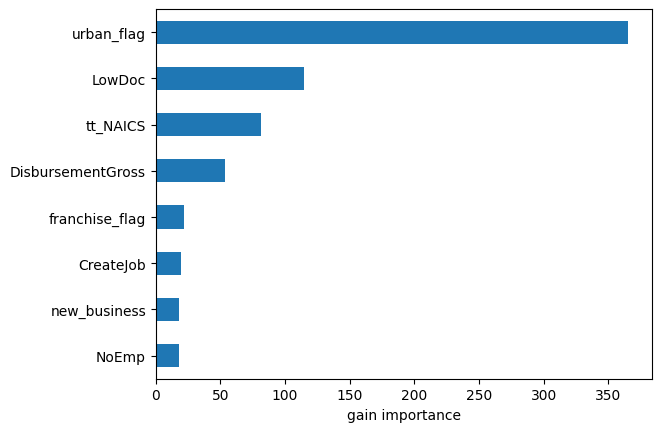

In [54]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A11_PLOT_importance_gain.png'))

##### Permutation Importance

In [55]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [56]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [57]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,tt_NAICS,0.082962,0.082962
3,DisbursementGross,0.066331,0.066331
5,urban_flag,0.035063,0.035063
1,CreateJob,0.020128,0.020128
2,LowDoc,0.014819,0.014819


In [58]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('A11_DATA_importance_perturb.csv'),
            index=False)

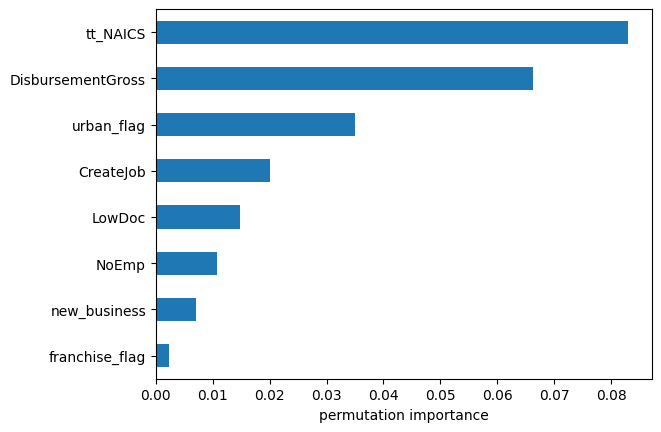

In [59]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('A11_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [61]:
results = partial_dependence(xgb_model, train_df[predictor_features], enc_val.columns[0])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [62]:
plt.close()

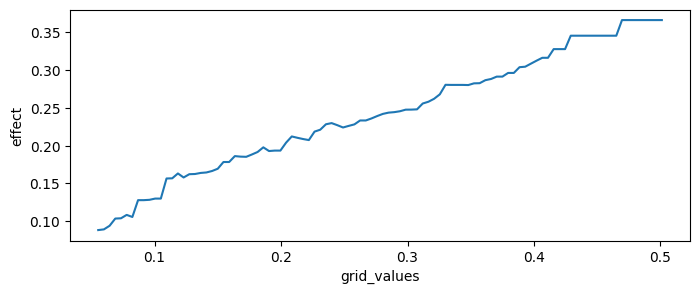

In [63]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('A11_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')